## Estimate the channel using music signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import wave
from pydub import AudioSegment
from scipy import signal
from scipy.io import wavfile #audio i/o
from IPython.display import Audio #listening to audio
import thinkdsp
%matplotlib inline

In [2]:
# Helper function for convert mp3 file to wav file
def Mp3ToWav(ifilename, ofilename):
    song = AudioSegment.from_mp3(ifilename)
    song.export(ofilename , format="wav")
    

In [3]:
# Self implemented CrossCorrelation function
def CrossCorrelation(x, y):
    N = len(x)+len(y)-1
    zpad_x = np.append(x,np.array([0 for i in range(N-len(x))]))
    zpad_y = np.append(y,np.array([0 for i in range(N-len(y))]))
    fft_x = np.fft.fft(x,N)
    fft_y = np.fft.fft(y,N)
    fft_s = fft_x*np.conjugate(fft_y)
    s = np.real(np.fft.ifft(fft_s))
    return np.append(s[int(N/2)+1:],s[:int(N/2)+1])

"""
Test AutoCorrelation function
"""
x = [-1,2,1]
y = [-1,2,1]
s = CrossCorrelation(x,y)
ans = np.correlate(x, y, 'full')
print(s)
print(ans)

[-1.00000000e+00  2.42931577e-17  6.00000000e+00  2.42931577e-17
 -1.00000000e+00]
[-1  0  6  0 -1]


In [4]:
# Self-defined function for loading the wav file and plot the waveform
def DisplayWave(filename, channel, lbound, rbound):
    '''
    channel = 2 : both channels
    channel = 0 : left channel
    channel = 1 : right channel
    '''
    sRate, data = wavfile.read(filename)
    if channel < 2:
        samples = data[lbound: rbound, channel]
    else:
        samples = data[lbound: rbound]
    length = samples.shape[0]/sRate
    print(samples.shape)
    print('length:{}s'.format(length))
    print('SampleRate:{}Hz'.format(sRate))
    time = np.linspace(0., length, samples.shape[0])
    if channel == 2:
        plt.plot(time, samples[:,0], label="Left channel")
        plt.plot(time, samples[:,1], label="Right channel")
    elif channel == 1:
        plt.plot(time, samples, label="Right channel")
    else:
        plt.plot(time, samples, label="Left channel")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    return samples

In [5]:
# Helper function for plot the spectrum of the input signal using w as x-axis
def MakeSpectrumW(t_samples):
    t_sample_rfft = np.fft.rfft(t_samples, 512)
    print(len(t_sample_rfft))
    w = np.linspace(0, np.pi, len(t_sample_rfft))
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(w,20*np.log10(np.absolute(t_sample_rfft)))
    plt.xlabel('$\omega$')
    plt.ylabel('Magnitude [dB]')
    plt.title('The magnitude response of the system')

    plt.subplot(122)
    plt.plot(w, np.angle(t_sample_rfft))
    plt.xlabel('$\omega$')
    plt.ylabel('Phase')
    plt.title('The phase spectrum of the system')

In [6]:
# Helper function for plot the spectrum of the input signal using Hz as x-axis
def MakeSpectrumHz(sampling_rate, fft_size, samples):
    t = np.arange(0, 1.0, 1.0/sampling_rate)
    xs = samples[:fft_size]
    xf = np.fft.rfft(xs)
    freqs = np.linspace(0, sampling_rate/2, fft_size/2+1)
    xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.plot(t[:fft_size], xs)
    plt.xlabel(u"Time(S)")
    plt.ylabel("Amplitude")
    plt.subplot(122)
    plt.plot(freqs, xfp)
    plt.xlabel(u"Freq(Hz)")
    plt.ylabel("Magnitude[dB]")
    plt.subplots_adjust(hspace=0.4)
    plt.show()


(8820,)
length:0.2s
SampleRate:44100Hz


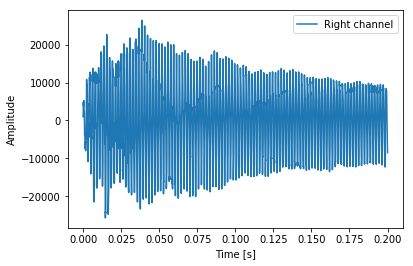

C:\Users\lhf\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


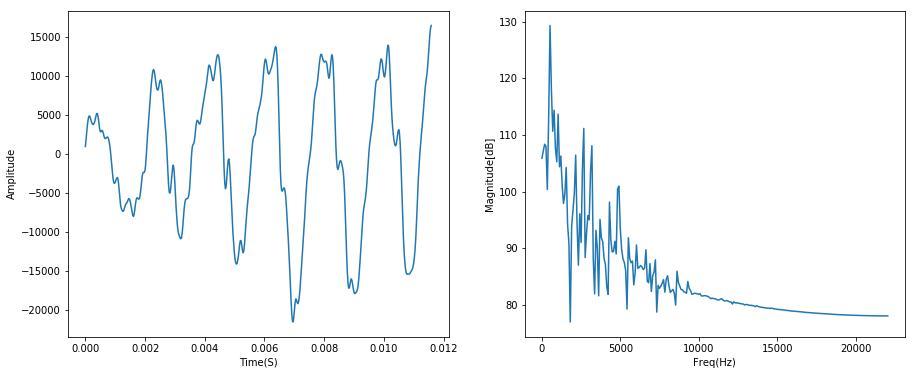

257


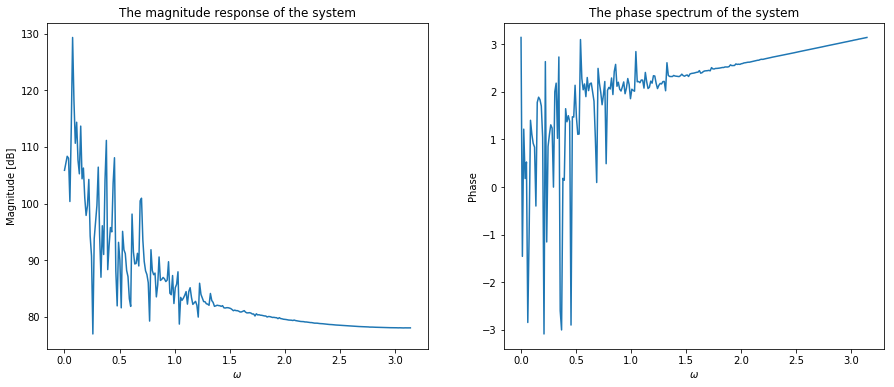

In [7]:
t_samples = DisplayWave("music.wav", 1, 12604, int(44100*0.2)+12604)
#r_samples_inv = DisplayWave("Spot1_inv_right_channel.wav", 2, 44100*3, 44100*13)
#r_samples_norm = DisplayWave("Spot1_normal_right_channel.wav", 2, 0, 44100*10)
MakeSpectrumHz(44100, 512, t_samples)
MakeSpectrumW(t_samples)

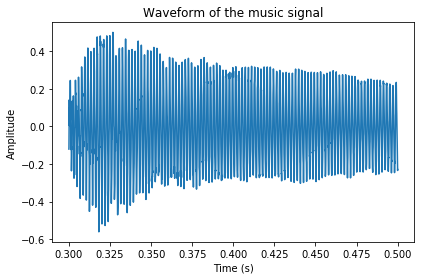

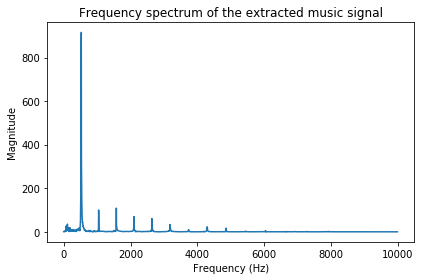

In [8]:
# Extract a segment of the music signal and analyze the frequency response
mt_wave = thinkdsp.read_wave("music.wav")
#mt_spectrum = mt_wave.make_spectrum()
#mt_spectrum.plot()
mt_wave_segment = mt_wave.segment(start = 0.3, duration = 0.2)
mt_wave_segment.plot()
thinkdsp.decorate(xlabel='Time (s)', ylabel = "Amplitude", title = "Waveform of the music signal")
mt_spectrum_seg = mt_wave_segment.make_spectrum()
plt.figure()
mt_spectrum_seg.plot(high = 10000)
thinkdsp.decorate(xlabel='Frequency (Hz)', ylabel = "Magnitude", title = "Frequency spectrum of the extracted music signal")
mt_wave_segment.make_audio()

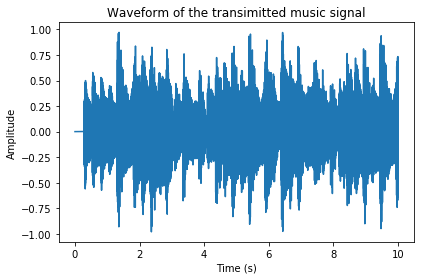

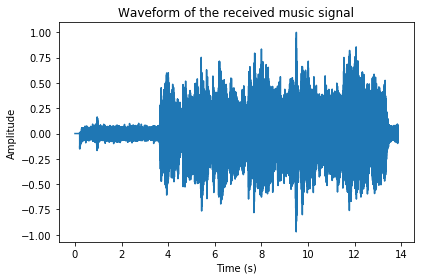

In [16]:
music = thinkdsp.read_wave('music.wav').segment(start = 0, duration = 10)
music.plot()
thinkdsp.decorate(xlabel = "Time (s)", ylabel = "Amplitude", title = "Waveform of the transimitted music signal")
recv = thinkdsp.read_wave('Spot1_inv_right_channel.wav')
plt.figure()
recv.plot()
thinkdsp.decorate(xlabel = "Time (s)", ylabel = "Amplitude", title = "Waveform of the received music signal")
recv.make_audio()

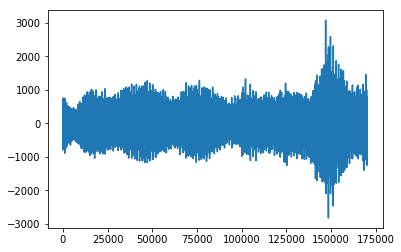

In [17]:
corr = np.correlate(recv.ys, music.ys, 'valid')
start = list(corr).index(np.max(corr))
plt.figure()
plt.plot(corr)

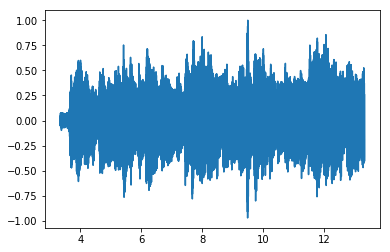

In [20]:
recv_seg = recv.segment(start = start/44100, duration = 10)
recv_seg.plot()
recv_seg.make_audio()

In [29]:
music_spce = music.make_spectrum()
np.abs(music_spce.hs[-100:])

array([0.28349841, 0.27355837, 0.28289356, 0.28748536, 0.28561362,
       0.28302532, 0.28340778, 0.28274488, 0.28532235, 0.28224358,
       0.28319839, 0.28388424, 0.28876115, 0.2903368 , 0.27658285,
       0.2821871 , 0.28679477, 0.28709192, 0.28687513, 0.28259955,
       0.28920189, 0.28849875, 0.28194818, 0.28496096, 0.2869557 ,
       0.28568085, 0.27861685, 0.28505775, 0.28925636, 0.2869956 ,
       0.28826002, 0.2839225 , 0.2919917 , 0.28284772, 0.28089084,
       0.2842048 , 0.28502358, 0.27809658, 0.28425876, 0.28545599,
       0.27749676, 0.2799514 , 0.28467034, 0.28934572, 0.28492083,
       0.28779138, 0.28466395, 0.28203605, 0.2850276 , 0.28737148,
       0.28114837, 0.2886472 , 0.28770758, 0.28933158, 0.28179836,
       0.28372294, 0.28227084, 0.28240697, 0.29020644, 0.2815997 ,
       0.28648656, 0.29164331, 0.28170468, 0.29410074, 0.28152068,
       0.28467371, 0.28809165, 0.287927  , 0.28291784, 0.28550503,
       0.27728853, 0.28594586, 0.28766204, 0.28306703, 0.28293

Text(0,0.5,'Amplitude')

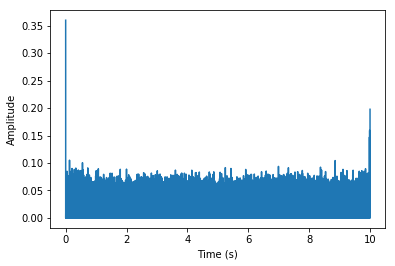

In [30]:
cir = np.fft.ifft(np.fft.fft(recv_seg.ys)/np.fft.fft(music.ys))
plt.figure()
x = np.linspace(0, len(cir)/44100, len(cir))
plt.plot(x, np.abs(cir))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

(611226, 2)
0.022675736961451247
44100


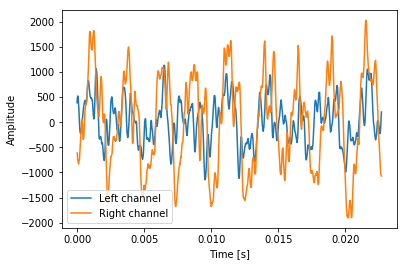

In [122]:
sampleRate, data = wavfile.read("Spot1_inv_right_channel.wav")
print(data.shape)
samples = data[44100*6:44100*6+1000,:]
length = samples.shape[0] / sampleRate
print(length)
print(sampleRate)
time = np.linspace(0., length, samples.shape[0])
plt.plot(time, samples[:, 0], label="Left channel")
plt.plot(time, samples[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()



In [123]:
# left channel
Audio(data = data[:,0], rate = sampleRate)

In [7]:
# right channel
Audio(data = data[:,1], rate = sampleRate)

(801738, 2)
0.022675736961451247
44100


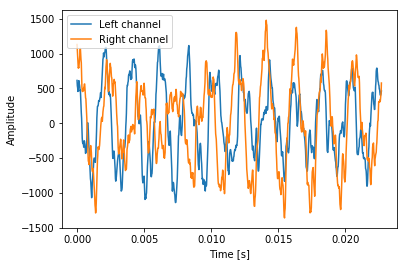

In [5]:
sampleRate, data = wavfile.read("Spot1_normal_right_channel.wav")
print(data.shape)
samples = data[44100*6:44100*6+1000,:]
length = samples.shape[0] / sampleRate
print(length)
print(sampleRate)
time = np.linspace(0., length, samples.shape[0])
plt.plot(time, samples[:, 0], label="Left channel")
plt.plot(time, samples[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

44100
(8119343, 2)
0.022675736961451247
44100


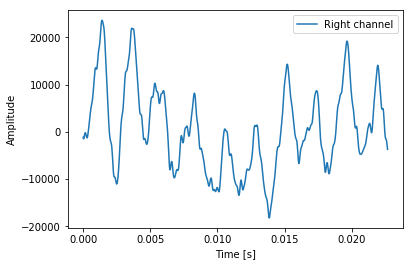

In [2]:
sampleRate, data = wavfile.read("music.wav")
print(sampleRate)
print(data.shape)
samples = data[44100*5:44100*5+1000,:]
length = samples.shape[0] / sampleRate
print(length)
print(sampleRate)
time = np.linspace(0., length, samples.shape[0])
#plt.plot(time, samples[:, 0], label="Left channel")
plt.plot(time, samples[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
Audio(data = data[:44100*10,1], rate = sampleRate)